In [153]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from enum import Enum


In [154]:
class DataTypes(Enum):
    RANDOM=1,
    GRID=2,
DATA_TARGET = DataTypes.RANDOM

match DATA_TARGET:
    case DataTypes.RANDOM:
        data_frames = {
            "numpy": pd.read_csv("../Implementations/python_numpy/rand_data.csv"),
            "tensorflow_cpu": pd.read_csv("../Implementations/python_tensorflow/rand_cpu_data.csv"),
            # "tensorflow_gpu": pd.read_csv("../Implementations/python_tensorflow/rand_gpu_data.csv"),
            "golang": pd.read_csv("../Implementations/go/rand_data.csv"),
            "static_rust": pd.read_csv("../Implementations/static_rust/rand_data.csv"),
            "dynamic_rust": pd.read_csv("../Implementations/dynamic_rust/rand_data.csv"),
        }
    case DataTypes.GRID:
        data_frames = {
            "numpy": pd.read_csv("../Implementations/python_numpy/grid_data.csv"),
            "tensorflow_cpu": pd.read_csv("../Implementations/python_tensorflow/grid_cpu_data.csv"),
            # "tensorflow_gpu": pd.read_csv("../Implementations/python_tensorflow/grid_gpu_data.csv"),
            "golang": pd.read_csv("../Implementations/go/grid_data.csv"),
            "static_rust": pd.read_csv("../Implementations/static_rust/grid_data.csv"),
            "dynamic_rust": pd.read_csv("../Implementations/dynamic_rust/grid_data.csv"),
        }

In [155]:
all_data = pd.DataFrame()

for data_frame_name, data_frame in data_frames.items():
    data_frame["implementation"] = data_frame_name
    data_frame["time"] /= 1E9
    data_frame["threads"] = data_frame.get("threads", 1)
    data_frame["batchsize"] = data_frame.get("batchsize", 1)
    data_frame["effective_multiplications"] = data_frame["trials"] * data_frame["multiplications"]
    all_data = pd.concat([all_data, data_frame],ignore_index=True)
display(all_data)

match DATA_TARGET:
    case DataTypes.RANDOM:
        all_data.to_csv("AggregatedRandom.csv")
    case DataTypes.GRID:
        all_data.to_csv("AggregatedGrid.csv")


,trials,multiplications,threads,time,implementation,batchsize,effective_multiplications
0,693,257,8,1.160164,numpy,1,178101
1,82,37,1,0.113183,numpy,1,3034
2,476,350,4,1.044544,numpy,1,166600
3,38,139,8,0.123874,numpy,1,5282
4,523,856,1,2.617269,numpy,1,447688
...,...,...,...,...,...,...,...
9165,1594,1103,8,0.689467,dynamic_rust,1,1758182
9166,120,617,8,0.041226,dynamic_rust,1,74040
9167,431,666,2,0.289983,dynamic_rust,1,287046
9168,423,32,1,0.029291,dynamic_rust,1,13536


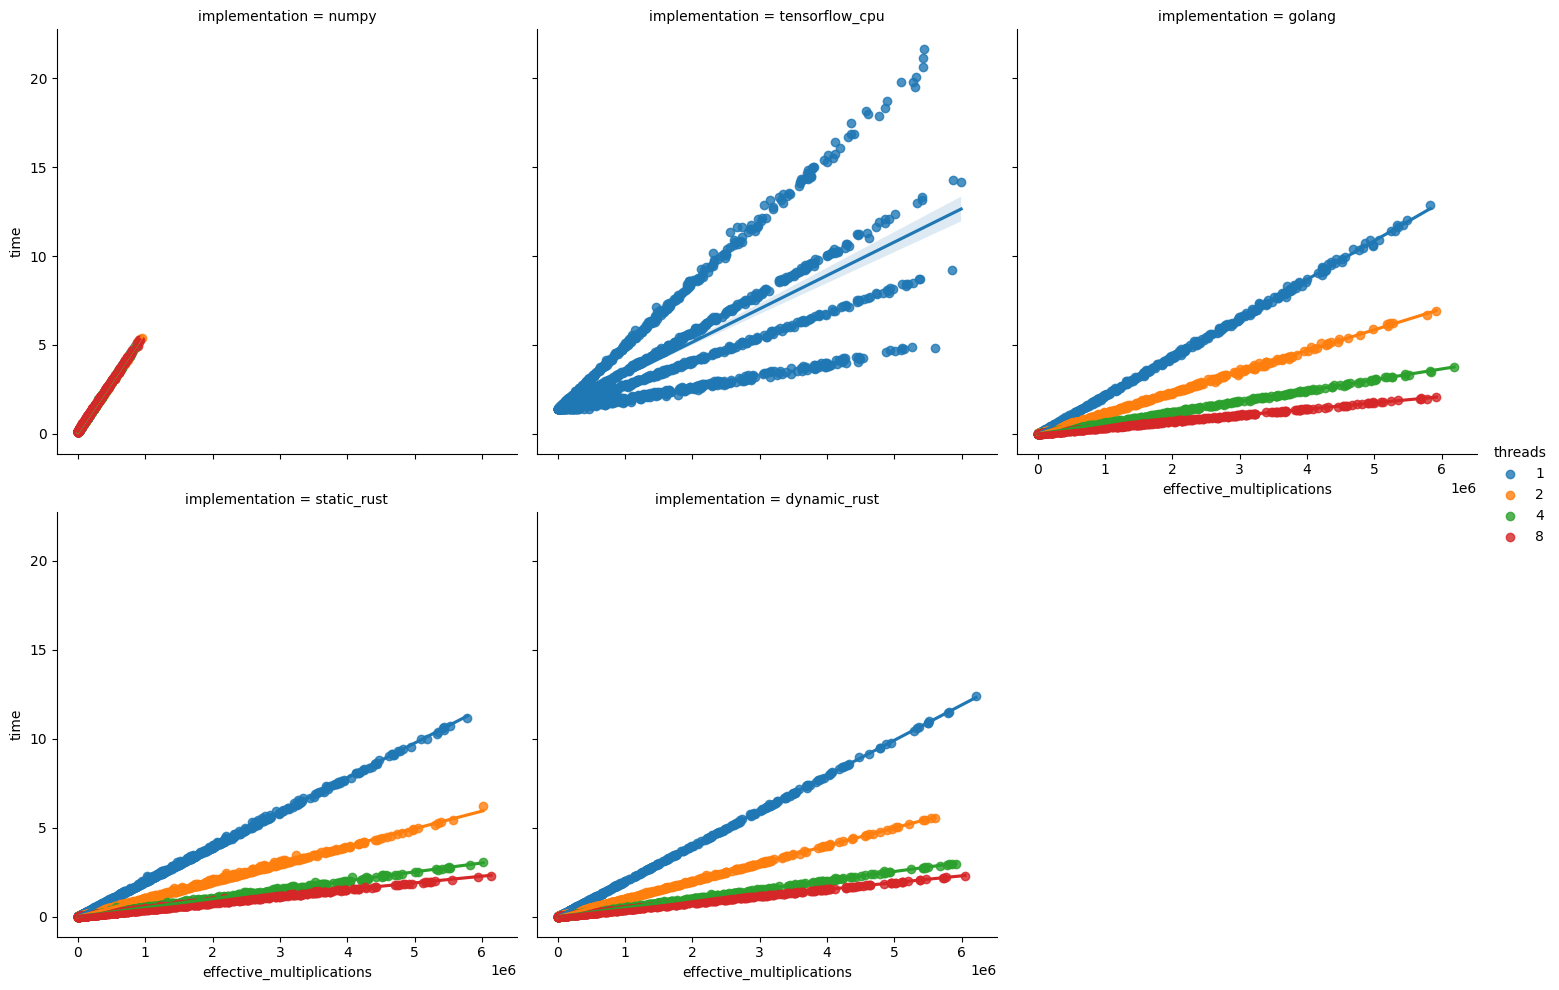

In [124]:
sns.lmplot(data=all_data, x="effective_multiplications", y="time", col="implementation", hue="threads", col_wrap=3)

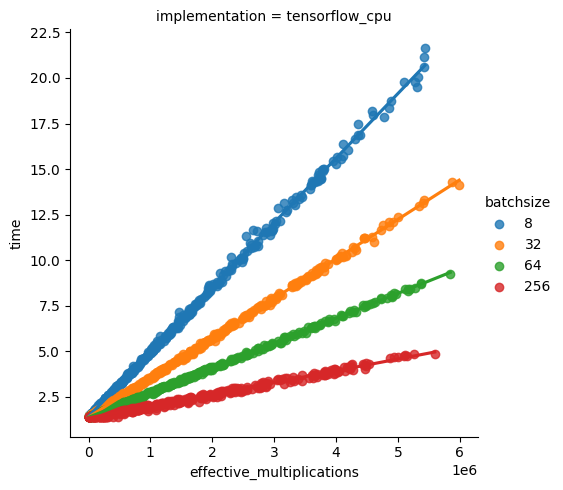

In [125]:
target_data = all_data.loc[(all_data["implementation"] == "tensorflow_cpu") | (all_data["implementation"] == "tensorflow_gpu")]

sns.lmplot(data=target_data, x="effective_multiplications", y="time", col="implementation", hue="batchsize")

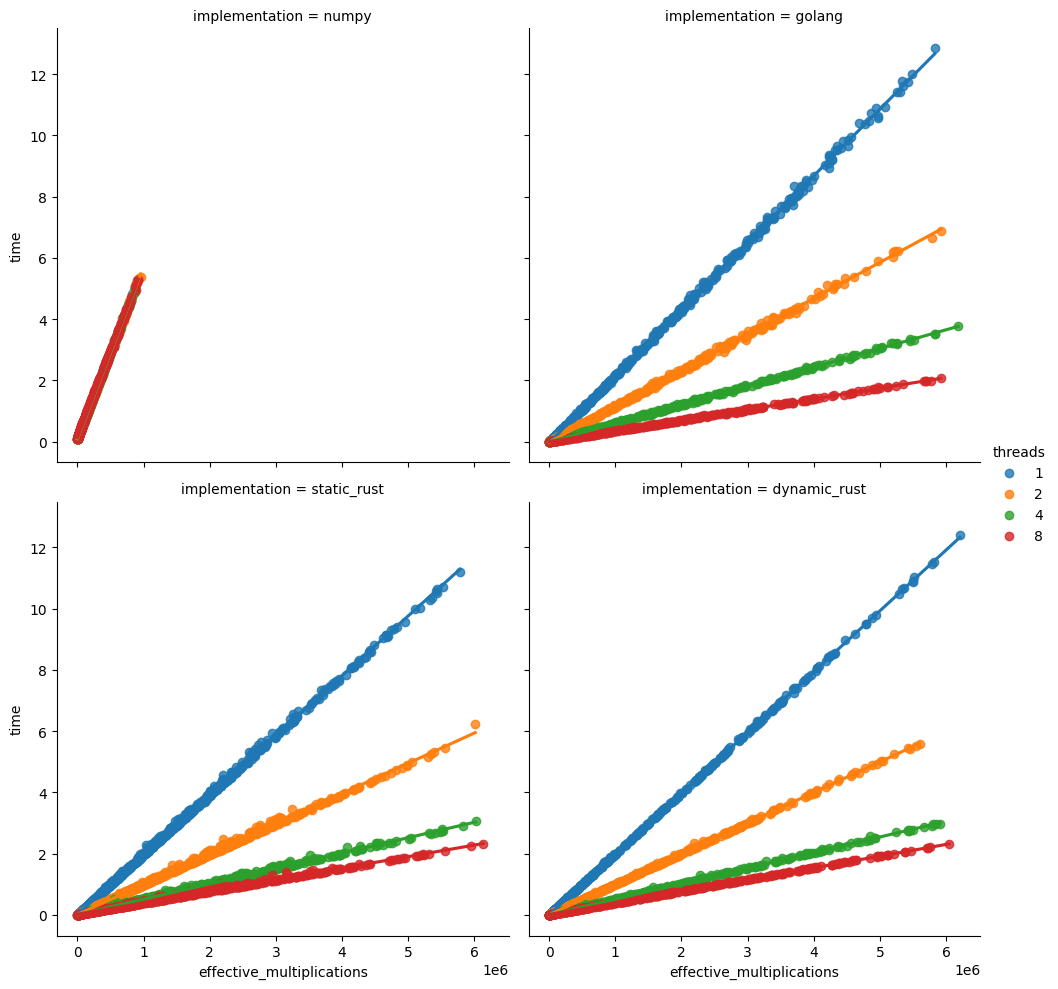

In [126]:
target_data = all_data.copy()
target_data = target_data.drop(target_data[target_data["implementation"] == "tensorflow_cpu"].index)
target_data = target_data.drop(target_data[target_data["implementation"] == "tensorflow_gpu"].index)

sns.lmplot(data=target_data, x="effective_multiplications", y="time", col="implementation", hue="threads", col_wrap=2)

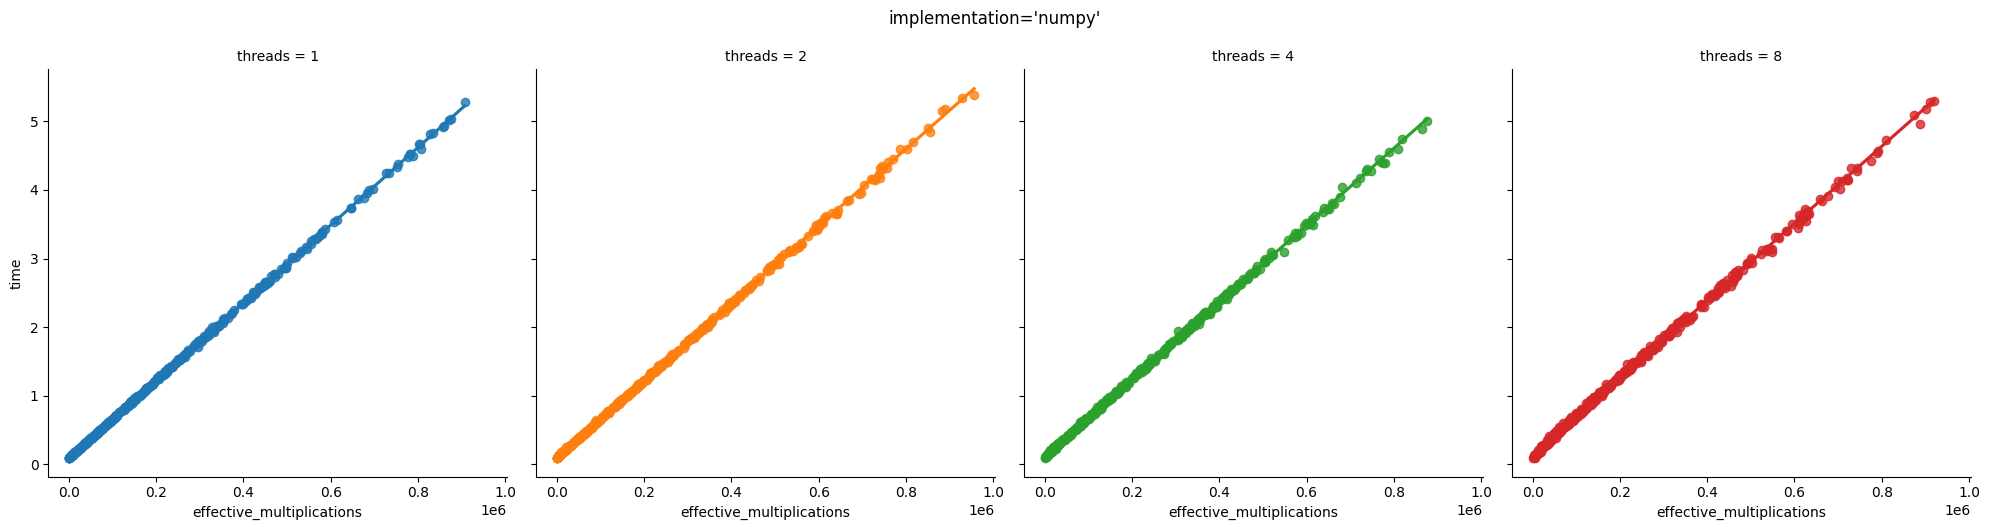

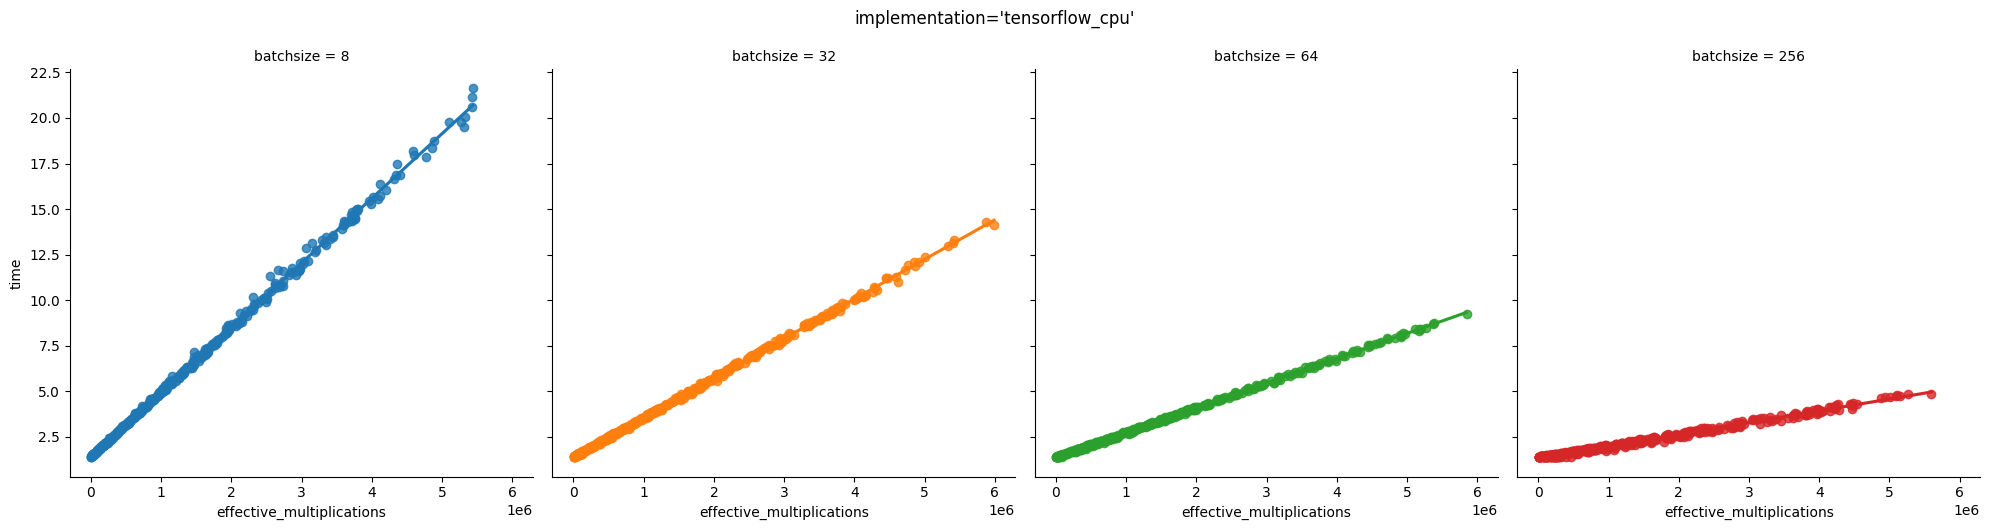

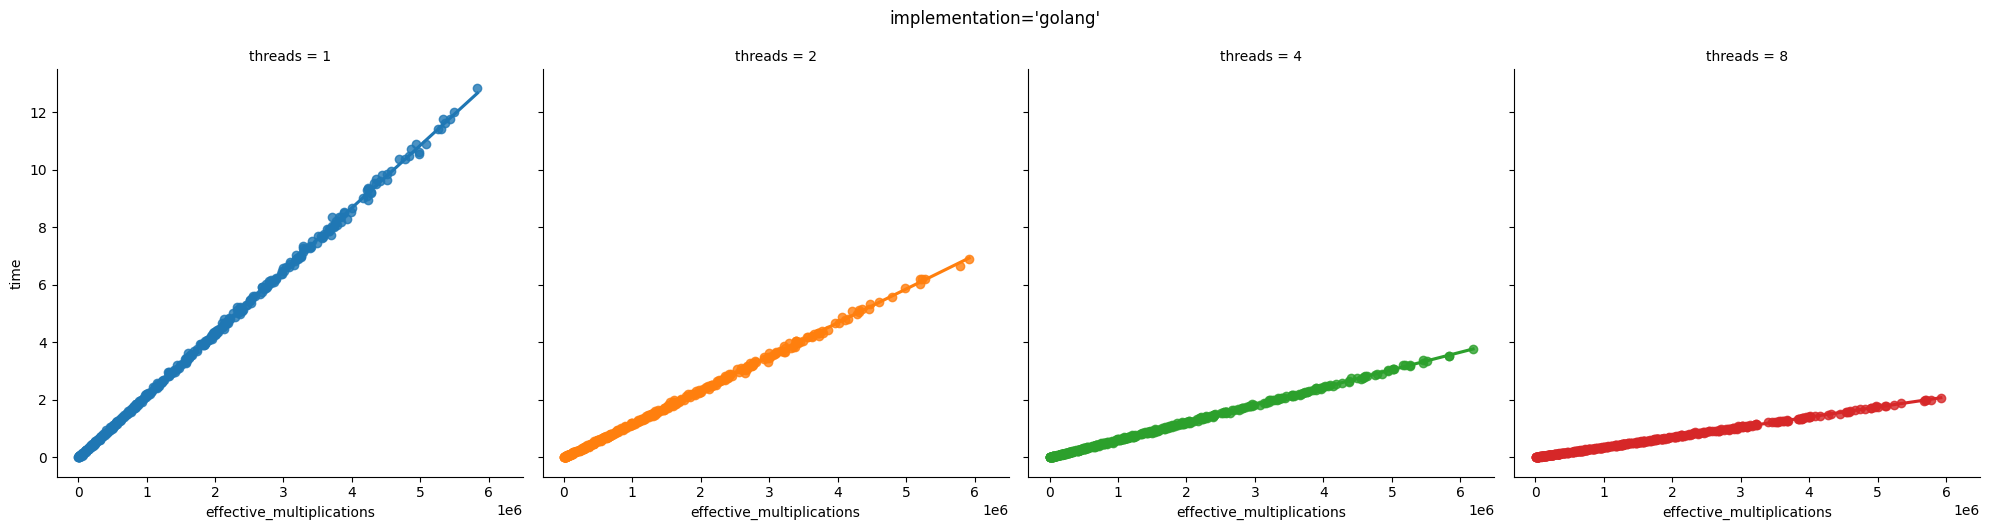

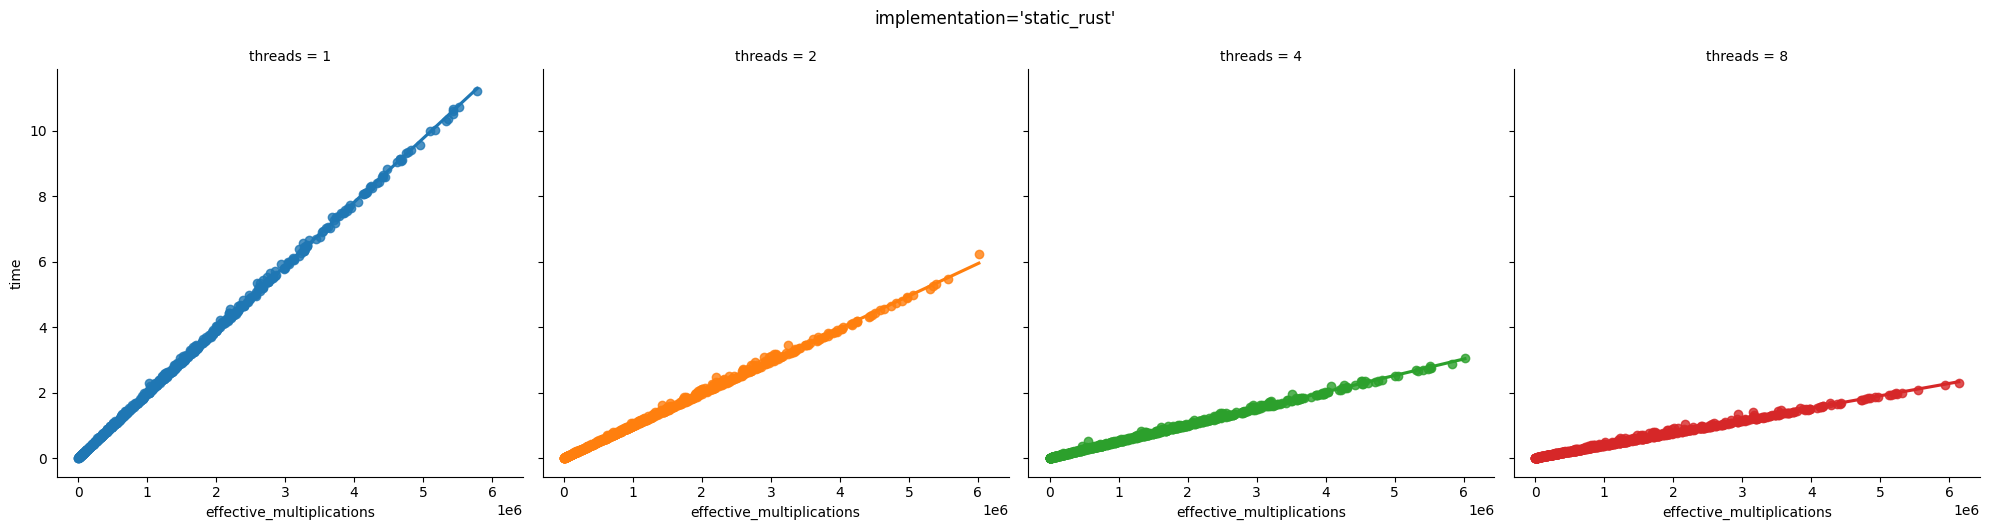

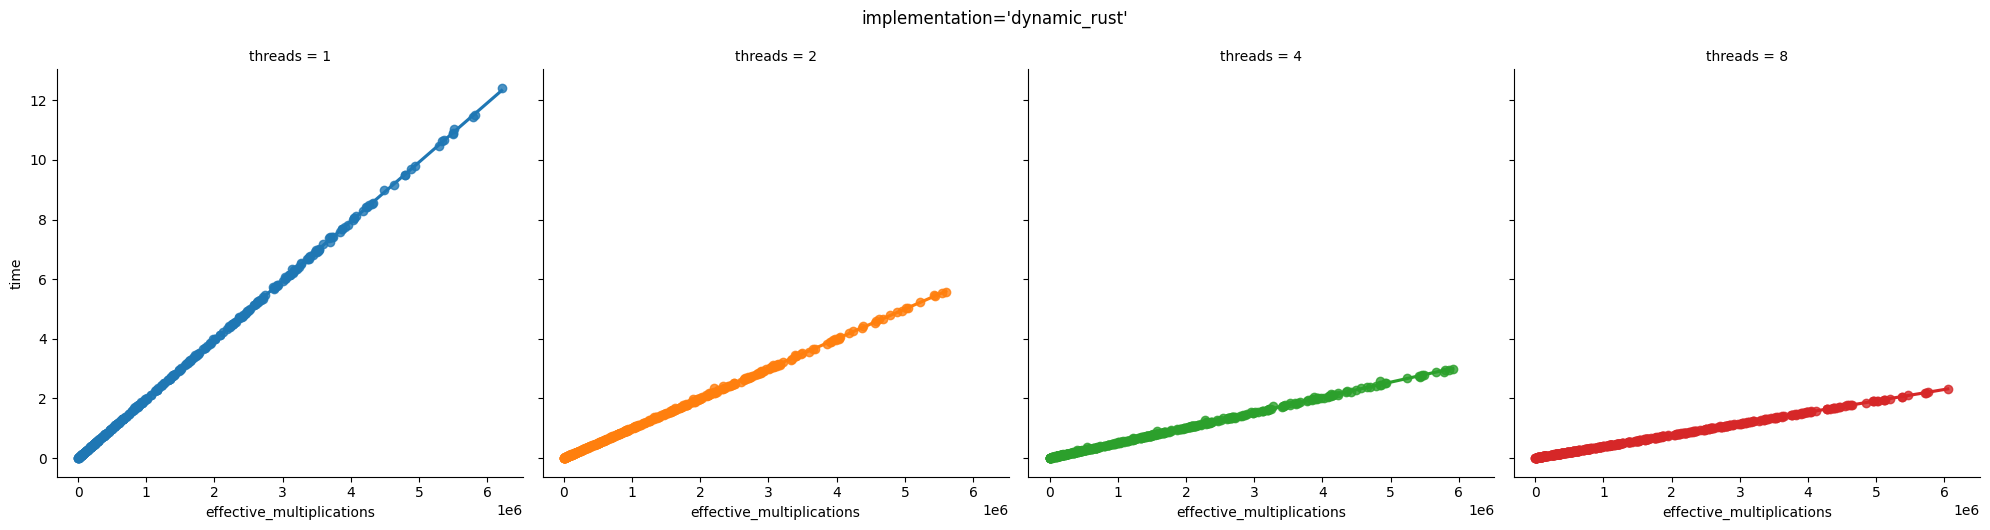

In [131]:
target_data = all_data
# target_data = all_data.drop(all_data[all_data["implementation"] == "tensorflow_cpu"].index)
# target_data = target_data.drop(all_data[all_data["implementation"] == "tensorflow_gpu"].index)
# target_data = target_data.drop(all_data[all_data["implementation"] == "numpy"].index)

for implementation in target_data.implementation.unique():
    col = "threads" if not implementation.startswith("tensorflow") else "batchsize"
    curr_plot = sns.lmplot(data=target_data.loc[target_data["implementation"]==implementation], x="effective_multiplications", y="time", col=col, hue=col)
    curr_plot.fig.suptitle(f"{implementation=}", y=1.05)

(-0.00025289560705393235, 0.005590794648407758) (-0.0020398727061352166, 0.0566671098971028)


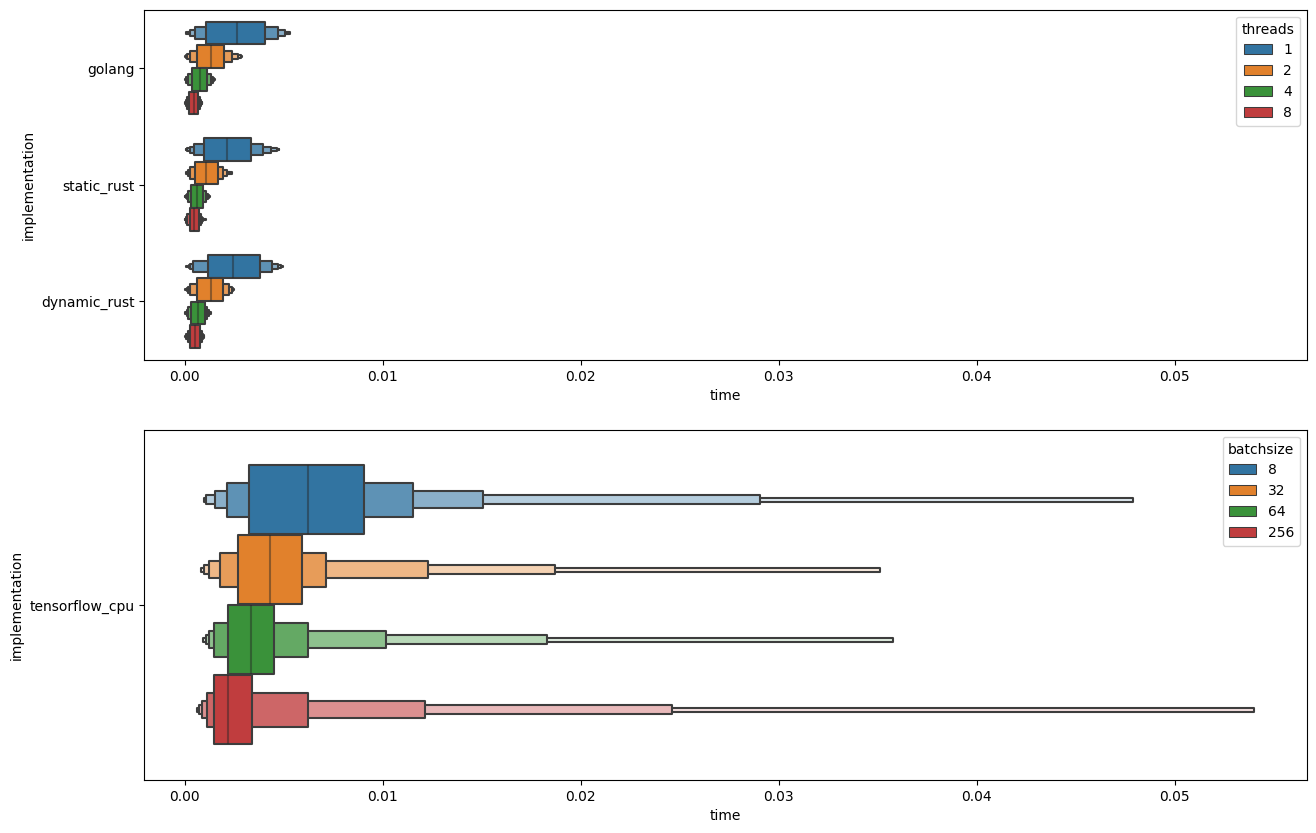

In [147]:
target_data = all_data.copy()
target_data["time"] /= target_data["multiplications"]
target_data = target_data.drop(target_data[target_data["implementation"] == "numpy"].index)

fig, axes = plt.subplots(2,1,figsize=(15, 10))  

compiled_impl_data = target_data
compiled_impl_data = compiled_impl_data.drop(compiled_impl_data[compiled_impl_data["implementation"] == "numpy"].index)
compiled_impl_data = compiled_impl_data.drop(compiled_impl_data[compiled_impl_data["implementation"] == "tensorflow_cpu"].index)
plot1 = sns.boxenplot(data=compiled_impl_data, x="time", y="implementation", hue="threads", showfliers=False, ax=axes[0])

tensorflow_data = target_data
tensorflow_data = tensorflow_data.loc[tensorflow_data["implementation"].str.startswith("tensorflow")]
plot2 = sns.boxenplot(data=tensorflow_data, x="time", y="implementation", hue="batchsize", showfliers=False, ax=axes[1])

max_xlim=max(plot1.get_xlim(), plot2.get_xlim(), key=lambda x: x[1])
max_xlim = np.array(max_xlim)
axes[0].set_xlim(max_xlim)
axes[1].set_xlim(max_xlim)

plt.show()

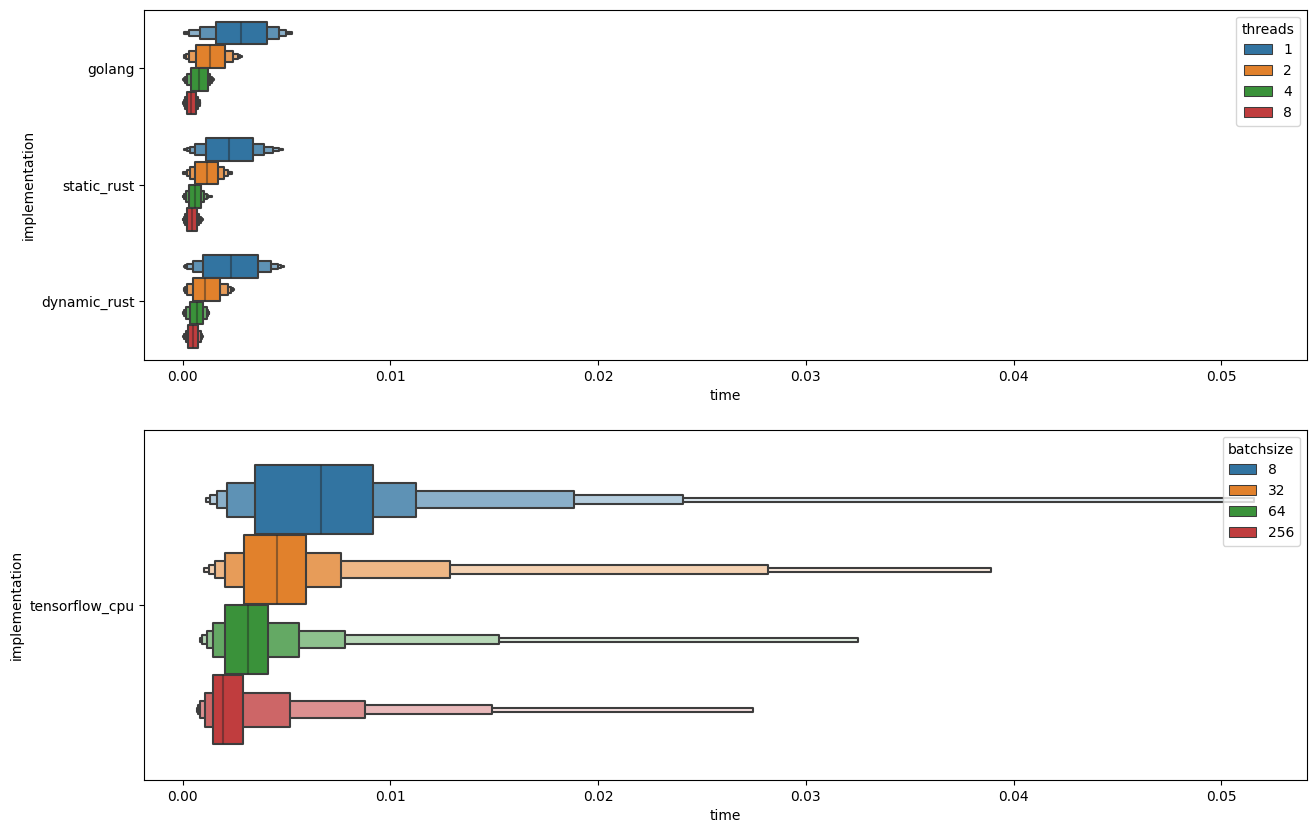

In [152]:
target_data = all_data.copy()
target_data["time"] /= target_data["trials"]
target_data = target_data.drop(target_data[target_data["implementation"] == "numpy"].index)

compiled_impl_data = target_data
compiled_impl_data = compiled_impl_data.drop(compiled_impl_data[compiled_impl_data["implementation"] == "numpy"].index)
compiled_impl_data = compiled_impl_data.drop(compiled_impl_data[compiled_impl_data["implementation"] == "tensorflow_cpu"].index)

fig, axes = plt.subplots(2,1,figsize=(15, 10))  
plot1 = sns.boxenplot(data=compiled_impl_data, x="time", y="implementation", hue="threads", showfliers=False, ax=axes[0])

tensorflow_data = target_data
tensorflow_data = tensorflow_data.loc[tensorflow_data["implementation"].str.startswith("tensorflow")]
plot2 = sns.boxenplot(data=tensorflow_data, x="time", y="implementation", hue="batchsize", showfliers=False, ax=axes[1])

max_xlim=max(plot1.get_xlim(), plot2.get_xlim(), key=lambda x: x[1])
max_xlim = np.array(max_xlim)
axes[0].set_xlim(max_xlim)
axes[1].set_xlim(max_xlim)

plt.show()